In [9]:
import tensorflow as tf
cpus = tf.config.experimental.list_physical_devices('cpu')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

from retinaface import RetinaFace
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import ntpath

img_path = 'imgs/Jang.jpg'

resp = RetinaFace.detect_faces(img_path)

print(resp)

{'face_1': {'score': 0.9990491271018982, 'facial_area': [173, 131, 465, 542], 'landmarks': {'right_eye': [241.81001, 300.3217], 'left_eye': [379.40344, 296.97186], 'nose': [306.318, 386.14328], 'mouth_right': [253.43904, 437.33792], 'mouth_left': [379.22433, 433.70105]}}}


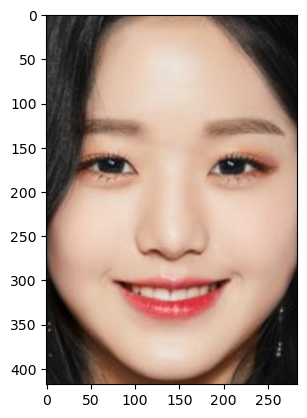

In [3]:
import cv2

img = cv2.imread(img_path)
img = img[:, :, ::-1]

facial_area = resp['face_1']['facial_area']
landmarks = resp['face_1']["landmarks"]
left_eye = landmarks["left_eye"]
right_eye = landmarks["right_eye"]
nose = landmarks["nose"]
mouth_right = landmarks["mouth_right"]
mouth_left = landmarks["mouth_left"]

face_img = img[facial_area[1]: facial_area[3], facial_area[0]: facial_area[2]]

plt.imshow(face_img)

1.786308025046008


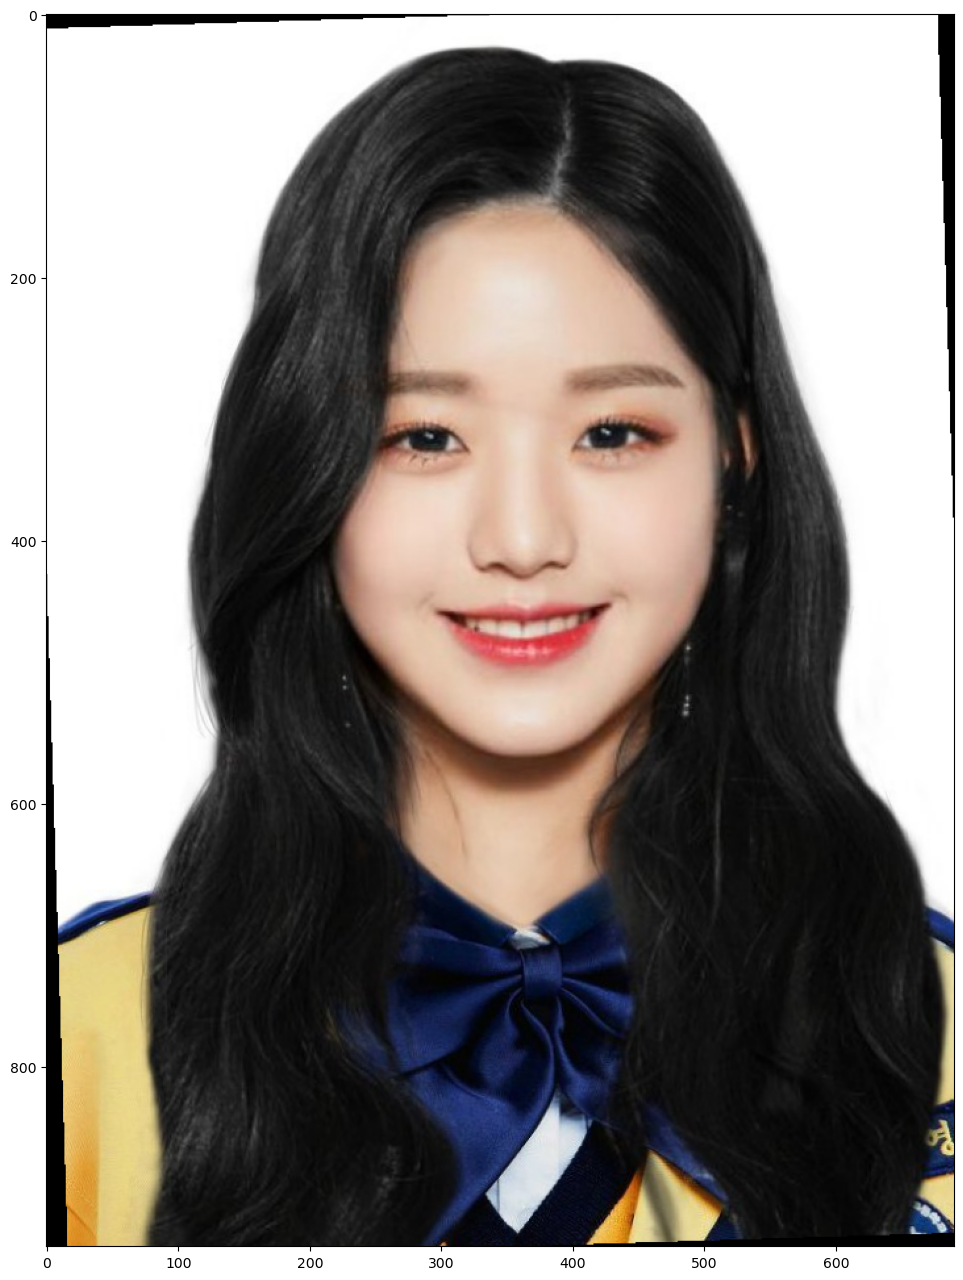

In [4]:
# swap
left_eye, right_eye = right_eye, left_eye

left_eye_x, left_eye_y = left_eye
right_eye_x, right_eye_y = right_eye

center_eyes = (int((left_eye_x + right_eye_x) / 2), int((left_eye_y + right_eye_y) / 2))

if left_eye_y > right_eye_y:
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock
else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock

#-----------------------
#find length of triangle edges

a = np.linalg.norm(np.array(left_eye) - np.array(point_3rd))
b = np.linalg.norm(np.array(right_eye) - np.array(point_3rd))
c = np.linalg.norm(np.array(right_eye) - np.array(left_eye))

if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    
    #PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0], floating point errors would produce cases violating this
    #In fact, we did come across a case where cos_a took the value 1.0000000169176173, which lead to a NaN from the following np.arccos step
    cos_a = min(1.0, max(-1.0, cos_a))
    
    
    angle = np.arccos(cos_a) #angle in radian
    angle = (angle * 180) / math.pi #radian to degree

    #-----------------------
    #rotate base image

    if direction == -1:
        angle = 90 - angle

    rotated_img = Image.fromarray(img)
    rotated_img = np.array(rotated_img.rotate(direction * angle, center=nose, resample=Image.Resampling.BILINEAR))

    if center_eyes[1] > nose[1]:
        rotated_img = Image.fromarray(rotated_img)
        rotated_img = np.array(rotated_img.rotate(180))

print(angle)
plt.figure(figsize=(16, 16))
plt.imshow(rotated_img)

(627, 627, 3)


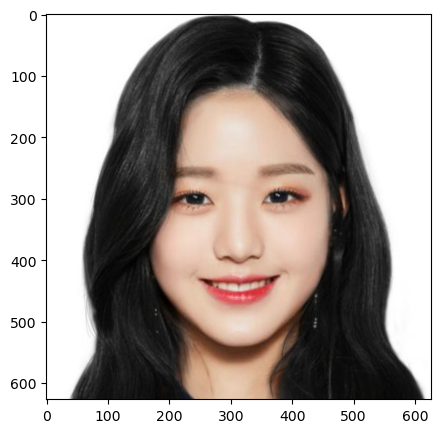

In [12]:
w, h = facial_area[2] - facial_area[0], facial_area[3] - facial_area[1]
cx, cy = (facial_area[0] + facial_area[2])/2, (facial_area[1] + facial_area[3]) / 1.8

margin_ratio = 1.5

crop_size = max(w, h) * margin_ratio

x1 = max(0, int(cx - crop_size *0.5))
x2 = int(cx + crop_size *0.5)
y1 = max(0, int(cy - crop_size *0.6))
y2 = int(cy + crop_size *0.4)

face_img = rotated_img[y1:y2, x1:x2]
crop_img = Image.fromarray(face_img)

print(face_img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(face_img)
crop_img.save(f'imgs/crop_{ntpath.basename(img_path)}')